In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as k

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-ad553f988aa6>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

labels = data[:,0]
data = data[:,1:]

dataNorm = data/np.max(data)

dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

In [3]:
dataT= torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

train_data,test_data,train_labels,test_labels = train_test_split(dataT, labelsT, test_size=0.1)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

batchsize = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
train_loader.dataset.tensors

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

Text(0.5, 1.0, 'Shifted (rolled)')

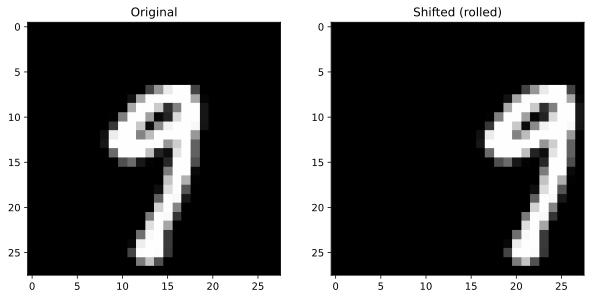

In [5]:
tmp = test_loader.dataset.tensors[0][0,:]
tmp = tmp.reshape(28,28)

tmpS = torch.roll(tmp,8,dims=1)

fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(tmp,cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(tmpS,cmap='gray')
ax[1].set_title('Shifted (rolled)')

In [6]:
for i in range(train_loader.dataset.tensors[0].shape[0]):

  img = train_loader.dataset.tensors[0][i,:,:]

  randroll = np.random.randint(-10,11)
  img = torch.roll(img, randroll,dims=1)

  train_loader.dataset.tensors[0][i,:,:,] = img

In [7]:
for i in range(test_loader.dataset.tensors[0].shape[0]):

  img = test_loader.dataset.tensors[0][i,:,:]

  randroll = np.random.randint(-10,11)
  img = torch.roll(img, randroll,dims=1)

  test_loader.dataset.tensors[0][i,:,:,] = img

In [18]:
def createMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(1,10,kernel_size=5,stride=1,padding=1)
      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)

      expectsize = np.floor((5+2*0-1)/1) + 1
      expectsize = 20*int(expectsize**2)

      self.fc1 = nn.Linear(expectsize,50)

      self.output = nn.Linear(50,10)


    def forward(self,x):

      x = F.relu(F.max_pool2d(self.conv1(x),2))

      x = F.relu(F.max_pool2d(self.conv2(x),2))

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))

      x = F.relu(self.fc1(x))

      return self.output(x)

  net =  mnistNet()

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [19]:
net,lossfun,optimizer = createMNISTNet()

for X,y in train_loader:
 yHat = net(X)

loss = lossfun(yHat,y)
print('')
print('Loss:')
print(loss)


Loss:
tensor(2.3277, grad_fn=<NllLossBackward0>)


In [20]:
num_epochs = 60

def trainModel():

  net,lossfun,optimizer = createMNISTNet()


  trainacc =[]
  testacc=[]
  losses = []

  for epochi in range(num_epochs):

    batchacc = []
    batchloss = []

    for data,labels in train_loader:

      yHat = net(data)
      loss = lossfun(yHat,labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      matches = torch.argmax(yHat,axis=1) == labels
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)

      batchacc.append(accuracyPct)

      batchloss.append(loss.item())

    trainacc.append(np.mean(batchacc))
    losses.append(np.mean(batchloss))

    tstacc = []
    for data,labels in test_loader:

      preddigits = net(data)
      tstacc.append(100* torch.mean((torch.argmax(preddigits,axis=1)==labels).float()))

    testacc.append(np.mean(tstacc))

  return net,trainacc,testacc,losses


In [21]:
net,trainacc,testacc,losses = trainModel()

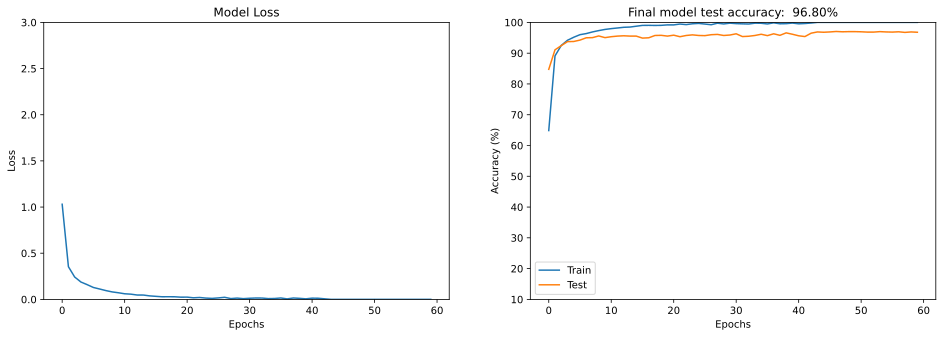

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model Loss')

ax[1].plot(trainacc,label='Train')
ax[1].plot(testacc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testacc[-1]: .2f}%')
ax[1].legend()